In [1]:
import numpy as np
import pandas as pd
import geopy as geo
import geopy.distance as dist

from tqdm import tqdm_notebook

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('val_public.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478287 entries, 0 to 478286
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             478287 non-null  int64  
 1   actual_price   15367 non-null   float64
 2   price          478287 non-null  float64
 3   start_date     462920 non-null  object 
 4   close_date     462920 non-null  object 
 5   sale_end_date  15367 non-null   object 
 6   brand          478287 non-null  object 
 7   model          478287 non-null  object 
 8   generation     478287 non-null  object 
 9   modification   478287 non-null  object 
 10  equipment      344571 non-null  object 
 11  body_type      478286 non-null  object 
 12  color          478287 non-null  object 
 13  year           478287 non-null  float64
 14  mileage        478287 non-null  int64  
 15  owners_count   478287 non-null  object 
 16  latitude       478287 non-null  float64
 17  longitude      478287 non-nul

In [4]:
data.describe()

,id,actual_price,price,year,mileage,latitude,longitude,crashes,is_taxi,is_carsharing
count,478287.000000,1.536700e+04,4.782870e+05,478287.000000,478287.000000,478287.000000,478287.000000,15367.000000,15343.000000,15343.000000
mean,244178.242660,1.600589e+06,8.352486e+05,2009.431536,154290.615582,54.065152,45.938668,0.538101,0.015838,0.001434
std,140959.073727,1.464759e+06,9.649817e+05,7.265361,95339.847425,4.984425,15.560953,0.899891,0.124852,0.037841
min,0.000000,2.000000e+04,1.000000e+04,1953.000000,1000.000000,41.459186,19.124550,0.000000,0.000000,0.000000
25%,122104.500000,7.600000e+05,2.850000e+05,2006.000000,88450.000000,51.991757,37.309706,0.000000,0.000000,0.000000
50%,244167.000000,1.198888e+06,5.700000e+05,2011.000000,143500.000000,55.687944,40.078556,0.000000,0.000000,0.000000
75%,366267.500000,1.949000e+06,1.000000e+06,2014.000000,200000.000000,56.484660,50.412361,1.000000,0.000000,0.000000
max,488322.000000,2.400000e+07,5.000000e+07,2022.000000,1000000.000000,69.733552,178.613873,13.000000,1.000000,1.000000


In [5]:
data.columns

Index(['id', 'actual_price', 'price', 'start_date', 'close_date',
       'sale_end_date', 'brand', 'model', 'generation', 'modification',
       'equipment', 'body_type', 'color', 'year', 'mileage', 'owners_count',
       'latitude', 'longitude', 'crashes', 'is_taxi', 'is_carsharing',
       'description'],
      dtype='object')

In [6]:
test.columns

Index(['id', 'sale_end_date', 'brand', 'model', 'generation', 'modification',
       'equipment', 'body_type', 'color', 'year', 'mileage', 'owners_count',
       'latitude', 'longitude', 'crashes', 'is_taxi', 'is_carsharing',
       'description'],
      dtype='object')

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1611 entries, 0 to 1610
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1611 non-null   int64  
 1   sale_end_date  1611 non-null   object 
 2   brand          1611 non-null   object 
 3   model          1611 non-null   object 
 4   generation     1611 non-null   object 
 5   modification   1611 non-null   object 
 6   equipment      699 non-null    object 
 7   body_type      1611 non-null   object 
 8   color          1611 non-null   object 
 9   year           1611 non-null   float64
 10  mileage        1611 non-null   int64  
 11  owners_count   1611 non-null   object 
 12  latitude       1611 non-null   float64
 13  longitude      1611 non-null   float64
 14  crashes        1611 non-null   float64
 15  is_taxi        1610 non-null   float64
 16  is_carsharing  1610 non-null   float64
 17  description    1611 non-null   object 
dtypes: float

Заполним пропущенные значения для столбцов crashes, is_taxi, is_carsharing нулевыми значениями

In [8]:
data['crashes'] = data['crashes'].fillna(0.)
data['is_taxi'] = data['is_taxi'].fillna(0.)
test['is_taxi'] = test['is_taxi'].fillna(0.)
data['is_carsharing'] = data['is_carsharing'].fillna(0.)
test['is_carsharing'] = test['is_carsharing'].fillna(0.)

Заполним пропущенные значения для столбца equipment значением Unknown

In [9]:
data['equipment'] = data['equipment'].fillna('Unknown')
test['equipment'] = test['equipment'].fillna('Unknown')

Заполним пропущенное значение body_type для Hyundai Sonata значением Седан

In [10]:
data['body_type'] = data['body_type'].fillna('Седан')

Так как в столбце sale_end_date содержится дата сделки с дилером, а в столбце close_date дата закрытия объявления, то заполним пропущенные значения в столбце sale_end_date значениями из столбца close_date

In [11]:
data['sale_end_date'] = data['sale_end_date'].fillna(data['close_date'])

Добавим новые признаки на основе столбца sale_end_date

In [12]:
data['month'] = data['sale_end_date'].str.split('-').str.get(1)
test['month'] = test['sale_end_date'].str.split('-').str.get(1)
data['day'] = data['sale_end_date'].str.split('-').str.get(2)
test['day'] = test['sale_end_date'].str.split('-').str.get(2)
data['sale_year'] = data['sale_end_date'].str.split('-').str.get(0)
test['sale_year'] = test['sale_end_date'].str.split('-').str.get(0)

In [13]:
data['month'] = pd.to_numeric(data['month'])
data['day'] = pd.to_numeric(data['day'])
data['sale_year'] = pd.to_numeric(data['sale_year'])
test['month'] = pd.to_numeric(test['month'])
test['day'] = pd.to_numeric(test['day'])
test['sale_year'] = pd.to_numeric(test['sale_year'])

In [14]:
data['day_of_week'] = pd.to_datetime(data['sale_end_date']).dt.dayofweek
test['day_of_week'] = pd.to_datetime(test['sale_end_date']).dt.dayofweek
data['day_of_year'] = pd.to_datetime(data['sale_end_date']).dt.dayofyear
test['day_of_year'] = pd.to_datetime(test['sale_end_date']).dt.dayofyear

In [22]:
data.loc[data['actual_price'].isna(), 'actual_price'] = data.loc[data['actual_price'].isna(), 'price']

Добавим новый признак - расстояние от Москвы до места продажи

In [25]:
Moscow = [55.755815, 37.617311]

In [26]:
dist_moscow = []

for index, row in tqdm_notebook(data.iterrows()):
    dist_moscow = np.append(dist_moscow,
                            dist.distance(Moscow, [row['latitude'], row['longitude']]).km)
    
data['dist_moscow'] = dist_moscow

dist_moscow = []

for index, row in tqdm_notebook(test.iterrows()):
    dist_moscow = np.append(dist_moscow,
                            dist.distance(Moscow, [row['latitude'], row['longitude']]).km)
    
test['dist_moscow'] = dist_moscow

C:\Users\aleks\AppData\Local\Temp\ipykernel_26168\3815543329.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm_notebook(data.iterrows()):


0it [00:00, ?it/s]

C:\Users\aleks\AppData\Local\Temp\ipykernel_26168\3815543329.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, row in tqdm_notebook(test.iterrows()):


0it [00:00, ?it/s]

In [27]:
data['close_date'] = pd.to_datetime(data['close_date'])
data['start_date'] = pd.to_datetime(data['start_date'])

Добавим новый признак - время, которое объявление было на сайте. Для тестовых данных заполним пропущенные значения медианным значением для каждой модели

In [28]:
data['sell_time'] = data['close_date'] - data['start_date']
data['sell_time'] = data['sell_time'].dt.days

In [29]:
test['sell_time'] = test['model'].map(data.groupby(by='model').agg({'sell_time': 'median'}).to_dict()['sell_time'])

In [30]:
data['sell_time'] = (data['sell_time']
                     .fillna(data['model']
                     .map(data.groupby(by='model')
                        .agg({'sell_time': 'median'})
                        .to_dict()['sell_time']
                     )))

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478287 entries, 0 to 478286
Data columns (total 29 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             478287 non-null  int64         
 1   actual_price   478287 non-null  float64       
 2   price          478287 non-null  float64       
 3   start_date     462920 non-null  datetime64[ns]
 4   close_date     462920 non-null  datetime64[ns]
 5   sale_end_date  478287 non-null  object        
 6   brand          478287 non-null  object        
 7   model          478287 non-null  object        
 8   generation     478287 non-null  object        
 9   modification   478287 non-null  object        
 10  equipment      478287 non-null  object        
 11  body_type      478287 non-null  object        
 12  color          478287 non-null  object        
 13  year           478287 non-null  float64       
 14  mileage        478287 non-null  int64         
 15  

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1611 entries, 0 to 1610
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1611 non-null   int64  
 1   sale_end_date  1611 non-null   object 
 2   brand          1611 non-null   object 
 3   model          1611 non-null   object 
 4   generation     1611 non-null   object 
 5   modification   1611 non-null   object 
 6   equipment      1611 non-null   object 
 7   body_type      1611 non-null   object 
 8   color          1611 non-null   object 
 9   year           1611 non-null   float64
 10  mileage        1611 non-null   int64  
 11  owners_count   1611 non-null   object 
 12  latitude       1611 non-null   float64
 13  longitude      1611 non-null   float64
 14  crashes        1611 non-null   float64
 15  is_taxi        1611 non-null   float64
 16  is_carsharing  1611 non-null   float64
 17  description    1611 non-null   object 
 18  month   

In [33]:
# replace \n with space in description
data['description'] = data['description'].str.replace('\n', ' ')

In [34]:
# delete multiple spaces
data['description'] = data['description'].str.replace(' +', ' ')

C:\Users\aleks\AppData\Local\Temp\ipykernel_26168\2091252278.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['description'] = data['description'].str.replace(' +', ' ')


In [36]:
data.to_csv('data_prepared.csv')
test.to_csv('test_prepaired.csv')

In [37]:
X_train, y_train = data.drop(['id', 'actual_price', 'price', 'sale_end_date', 'start_date', 'close_date', 'latitude', 'longitude', 'sale_year'], axis=1), data['price']

In [38]:
X_test = test.drop(['id', 'sale_end_date', 'latitude', 'longitude', 'sale_year'], axis=1)

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478287 entries, 0 to 478286
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   brand          478287 non-null  object 
 1   model          478287 non-null  object 
 2   generation     478287 non-null  object 
 3   modification   478287 non-null  object 
 4   equipment      478287 non-null  object 
 5   body_type      478287 non-null  object 
 6   color          478287 non-null  object 
 7   year           478287 non-null  float64
 8   mileage        478287 non-null  int64  
 9   owners_count   478287 non-null  object 
 10  crashes        478287 non-null  float64
 11  is_taxi        478287 non-null  float64
 12  is_carsharing  478287 non-null  float64
 13  description    478287 non-null  object 
 14  month          478287 non-null  int64  
 15  day            478287 non-null  int64  
 16  day_of_week    478287 non-null  int64  
 17  day_of_year    478287 non-nul

In [41]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1611 entries, 0 to 1610
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          1611 non-null   object 
 1   model          1611 non-null   object 
 2   generation     1611 non-null   object 
 3   modification   1611 non-null   object 
 4   equipment      1611 non-null   object 
 5   body_type      1611 non-null   object 
 6   color          1611 non-null   object 
 7   year           1611 non-null   float64
 8   mileage        1611 non-null   int64  
 9   owners_count   1611 non-null   object 
 10  crashes        1611 non-null   float64
 11  is_taxi        1611 non-null   float64
 12  is_carsharing  1611 non-null   float64
 13  description    1611 non-null   object 
 14  month          1611 non-null   int64  
 15  day            1611 non-null   int64  
 16  day_of_week    1611 non-null   int64  
 17  day_of_year    1611 non-null   int64  
 18  dist_mos

In [42]:
cat_features = ['brand', 'model', 'generation', 'modification', 'equipment', 'body_type', 'color', 'owners_count']
text_features = ['description']

In [43]:
from catboost import CatBoostRegressor

In [44]:
model = CatBoostRegressor(iterations=1000,
                          learning_rate=0.1,
                          depth=10,
                          loss_function='RMSE',
                          eval_metric='MAPE',
                          random_seed=42,
                          od_type='Iter',
                          od_wait=20,
                          task_type='GPU',
                          devices='0:1')

In [45]:
model.fit(X_train, y_train, cat_features=cat_features, text_features=text_features, verbose=True)

0:	learn: 2.1453534	total: 442ms	remaining: 7m 21s
1:	learn: 1.9677253	total: 580ms	remaining: 4m 49s
2:	learn: 1.8216097	total: 706ms	remaining: 3m 54s
3:	learn: 1.6859181	total: 837ms	remaining: 3m 28s
4:	learn: 1.5728807	total: 961ms	remaining: 3m 11s
5:	learn: 1.4547739	total: 1.09s	remaining: 3m
6:	learn: 1.3432385	total: 1.22s	remaining: 2m 53s
7:	learn: 1.2484882	total: 1.34s	remaining: 2m 46s
8:	learn: 1.1537382	total: 1.46s	remaining: 2m 40s
9:	learn: 1.0720651	total: 1.58s	remaining: 2m 36s
10:	learn: 1.0012195	total: 1.7s	remaining: 2m 32s
11:	learn: 0.9350753	total: 1.82s	remaining: 2m 29s
12:	learn: 0.8784945	total: 1.94s	remaining: 2m 27s
13:	learn: 0.8230773	total: 2.07s	remaining: 2m 25s
14:	learn: 0.7783652	total: 2.2s	remaining: 2m 24s
15:	learn: 0.7394638	total: 2.31s	remaining: 2m 22s
16:	learn: 0.7027626	total: 2.44s	remaining: 2m 20s
17:	learn: 0.6676695	total: 2.56s	remaining: 2m 19s
18:	learn: 0.6327147	total: 2.69s	remaining: 2m 18s
19:	learn: 0.6063248	total: 

In [46]:
pd.Series(model.predict(X_test)).to_csv('solution4.csv', header=False, index=False)

In [95]:
abc = data.groupby(by=['model', 'sale_end_date']).agg({'price': 'mean'}).reset_index()

In [109]:
abc['sale_end_date'] = pd.to_datetime(abc['sale_end_date'])

69


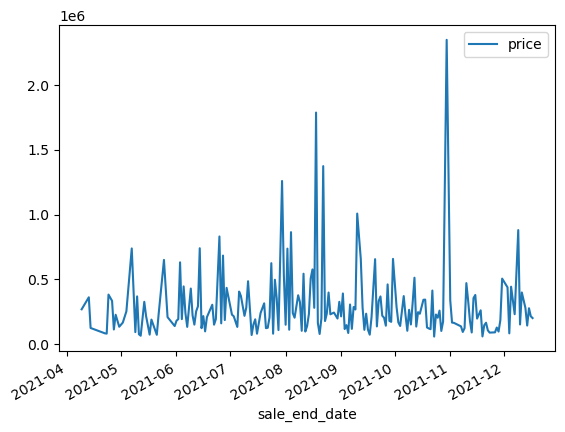

In [213]:
import random

i = random.choice(abc['model'].unique())
abc[abc['model'] == i][['sale_end_date', 'price']].plot(x='sale_end_date', y='price')
print(i)